<a href="https://colab.research.google.com/github/Spykabore15/road-damage-detection-yolo/blob/main/road_damage_detection01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Road damage detection with YOLO: Naive approach**

### Dependencies installation drive mounting setting up

In [ ]:

print("Dependencies Installation...")

!pip install -q ultralytics roboflow

# Checking GPU
import torch
print(f"\n✓ GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n✓ Installation ended!")

Dependencies Installation...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.1 MB/s eta 0:00:00

✓ GPU available: True
  GPU: NVIDIA L4
  VRAM: 23.80 GB

✓ Installation ended!


In [ ]:
from google.colab import drive
from google.colab import userdata
import os
from pathlib import Path
import shutil
from datetime import datetime

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create data structuring on Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/YOLO_RoadDamage')
CHECKPOINTS_DIR = DRIVE_ROOT / 'checkpoints'
BEST_WEIGHTS_DIR = DRIVE_ROOT / 'best_weights'
LOGS_DIR = DRIVE_ROOT / 'logs'

for directory in [DRIVE_ROOT, CHECKPOINTS_DIR, BEST_WEIGHTS_DIR, LOGS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"  ✓ {directory}")

# Create a unique name for this session
SESSION_NAME = f"yolov11s_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
SESSION_DIR = CHECKPOINTS_DIR / SESSION_NAME
SESSION_DIR.mkdir(exist_ok=True)

print(f"\n✓ Session: {SESSION_NAME}")
print(f"✓ Saving in: {SESSION_DIR}")


📁 Mounting Google Drive...
Mounted at /content/drive
  ✓ /content/drive/MyDrive/YOLO_RoadDamage
  ✓ /content/drive/MyDrive/YOLO_RoadDamage/checkpoints
  ✓ /content/drive/MyDrive/YOLO_RoadDamage/best_weights
  ✓ /content/drive/MyDrive/YOLO_RoadDamage/logs

✓ Session: yolov11s_20251113_180428
✓ Sauvegardes dans: /content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428


### Dataset importation from Roboflow

In [ ]:
from roboflow import Roboflow
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
print("Dataset downloading from Roboflow ...")

# ============= ROBOFLOW CONFIGURATION  =============
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
PROJECT = rf.workspace("alpha-nydx8").project("road-damage-detection-yodzc")
VERSION = PROJECT.version(1)
DATASET = VERSION.download("yolov11")
DATASET_PATH = DATASET.location
DATA_YAML = f"{DATASET_PATH}/data.yaml"

📦Dataset downloading from Roboflow ...
loading Roboflow workspace...
loading Roboflow project...


### Classes balancing

In [ ]:
import yaml
with open(DATA_YAML, 'r') as f:
  data_config = yaml.safe_load(f)

print(f"\n📊 Dataset info:")
print(f"  Classes: {data_config['nc']}")
print(f"  Names: {data_config['names']}")
print(f"  Train: {data_config['train']}")
print(f"  Val: {data_config['val']}")


📊 Dataset info:
  Classes: 5
  Names: ['alligator crack', 'longitudinal crack', 'other corruption', 'pothole', 'transverse crack']
  Train: ../train/images
  Val: ../valid/images


*Repartion of the dataset*:

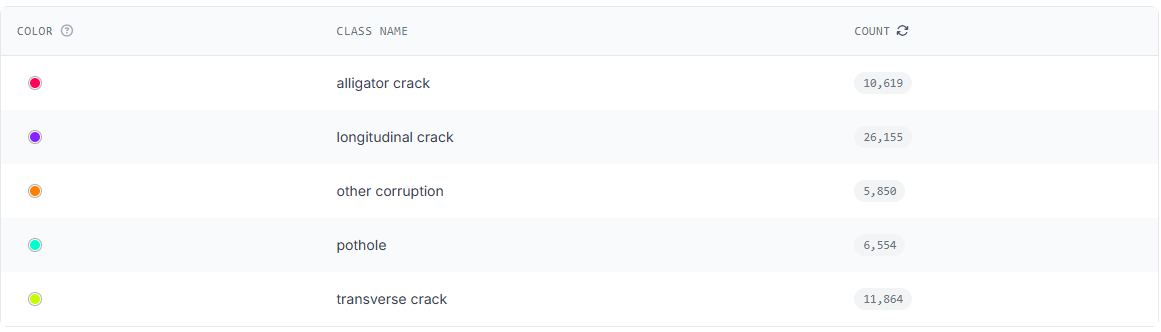


*We'll then use a weighted balancing in oder to pay more attention to the minority classes like pothole and other corruption*





In [ ]:
import yaml

print("Dataset Class Balancing Configuration ...")

# Classes statistics approximation ~~
class_counts = {
    'alligator crack': 10700,
    'longitudinal crack': 26000,
    'other corruption': 5950,
    'pothole': 6600,
    'transverse crack': 12000
}

# Calculate of the inverted weights
total = sum(class_counts.values())
weights = []
for class_name in data_config['names']:
    if class_name in class_counts:
        weight = total / (len(class_counts) * class_counts[class_name])
        weights.append(round(weight, 2))
    else:
        weights.append(1.0)

print(f"  Calculated weights: {weights}")

# Save the weights
weights_file = SESSION_DIR / 'class_weights.txt'
with open(weights_file, 'w') as f:
    f.write(f"Class weights: {weights}\n")
    for name, weight in zip(data_config['names'], weights):
        f.write(f"  {name}: {weight}\n")

print(f"✓ Weights saved: {weights_file}")



⚖️ Dataset Class Balancing Configuration ...
  Calculated weights: [1.14, 0.47, 2.06, 1.86, 1.02]
✓ Weights saved: /content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/class_weights.txt


### Auto Saver

Since we are expecting some hours of training time, we'll save the model weights every 10mns.
So, even if the session has to be interrupt for some reasons, we could still retrieve the last checkpoint and the best.pt at that time.

In [ ]:
import time
import threading

class AutoSaver:
    """Automatically saving weights during training"""

    def __init__(self, run_dir, session_dir, interval=600):
        """
        Args:
            run_dir: Folder containg runs YOLO (ie: runs/detect/train)
            session_dir: Folder of session on Drive
            interval: Saving Interval in sec (defaut: 10 min)
        """
        self.run_dir = Path(run_dir)
        self.session_dir = Path(session_dir)
        self.interval = interval
        self.running = False
        self.thread = None

    def _save_loop(self):
        """BSaving loop"""
        while self.running:
            try:
                # Wait
                time.sleep(self.interval)

                if not self.running:
                    break

                # Looking for files to save
                weights_dir = self.run_dir / 'weights'
                if weights_dir.exists():
                    # Copie last.pt
                    last_pt = weights_dir / 'last.pt'
                    if last_pt.exists():
                        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                        dest = self.session_dir / f'last_{timestamp}.pt'
                        shutil.copy2(last_pt, dest)
                        print(f"\n💾 Auto-save: {dest.name}")

                    # Copie best.pt
                    best_pt = weights_dir / 'best.pt'
                    if best_pt.exists():
                        dest_best = self.session_dir / 'best.pt'
                        shutil.copy2(best_pt, dest_best)

                # Copie results.csv
                results_csv = self.run_dir / 'results.csv'
                if results_csv.exists():
                    dest_csv = self.session_dir / 'results.csv'
                    shutil.copy2(results_csv, dest_csv)

            except Exception as e:
                print(f"\n Error auto-save: {e}")

    def start(self):
        """Automatic saving starting"""
        self.running = True
        self.thread = threading.Thread(target=self._save_loop, daemon=True)
        self.thread.start()
        print(f"✓ Auto-saving started (interval: {self.interval}s = {self.interval//60} min)")

    def stop(self):
        """Automatic saving stopping"""
        self.running = False
        if self.thread:
            self.thread.join(timeout=5)
        print("✓ Auto-save stopped")



### Hyperparameters configuration

In [ ]:
print("Training Configuration...")

# ============= HYPERPARAMETERS =============
EPOCHS = 150
BATCH_SIZE = 16
IMAGE_SIZE = 640
PATIENCE = 30
SAVE_PERIOD = 10

# Run fisrt without any augmentation
"""
# Augmentations
AUGMENT_CONFIG = {
    'hsv_h': 0.015,         # Hue
    'hsv_s': 0.7,           # Saturation
    'scale': 0.5,           # Scale
    'mosaic': 1.0,          # Mosaic augmentation
}
"""
# Learning rate
LR0 = 0.001
LRF = 0.01

# ============================================

config_info = f"""
Training Configuration:
  Model: YOLOv11s
  Epochs: {EPOCHS}
  Batch size: {BATCH_SIZE}
  Image size: {IMAGE_SIZE}
  Patience: {PATIENCE}
  Learning rate: {LR0} → {LR0 * LRF}

  Auto-save: Every 10 mins
  Checkpoint: Every {SAVE_PERIOD} epochs
"""

print(config_info)

# Saving configuration
with open(SESSION_DIR / 'config.txt', 'w') as f:
    f.write(config_info)



⚙️ Training Configuration...

Training Configuration:
  Model: YOLOv11s
  Epochs: 150
  Batch size: 16
  Image size: 640
  Patience: 30
  Learning rate: 0.001 → 1e-05
  
  Auto-save: Every 10 mins
  Checkpoint: Every 10 epochs



### A javascript code to keep the server alive

In [ ]:
# Keep Colab Alive
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Clicked on connect button");
     btn.click()
   }
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Clicked on ok button");
     btn.click()
   }
 }
 setInterval(ClickConnect, 60000)
'''))

print("✓ Keep-alive activate (every 60 s)")

<IPython.core.display.Javascript object>

✓ Keep-alive activate (every 60 s)


### Model Training

In [ ]:
from ultralytics import YOLO
import sys

print("=" * 60)
print("  ===> START TRAINING YOLO v11s <=== ")
print("=" * 60)

# Model loading
model = YOLO('yolo11s.pt')

# Create local runs folders
RUN_NAME = SESSION_NAME
RUN_DIR = Path(f'/content/runs/detect/{RUN_NAME}')

# Start auto-saving
auto_saver = AutoSaver(
    run_dir=RUN_DIR,
    session_dir=SESSION_DIR,
    interval=600
)
auto_saver.start()

try:
    # LAUCH TRAINING
    results = model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        patience=PATIENCE,
        save=True,
        save_period=SAVE_PERIOD,
        project='/content/runs/detect',
        name=RUN_NAME,
        exist_ok=True,
        pretrained=True,
        lr0=LR0,
        lrf=LRF
    )

    print("\n" + "=" * 60)
    print("  ✅ SUCCESS TRAINING  !")
    print("=" * 60)

except KeyboardInterrupt:
    print("\n⚠️ Training interupt by user")
except Exception as e:
    print(f"\n❌ Error during training: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Stop auto-saving
    auto_saver.stop()

    # FINAL SAVING on Drive
    print("\n💾 Final saving on Google Drive...")

    if RUN_DIR.exists():
        # Copie all the weights
        weights_dir = RUN_DIR / 'weights'
        if weights_dir.exists():
            for weight_file in weights_dir.glob('*.pt'):
                dest = SESSION_DIR / weight_file.name
                shutil.copy2(weight_file, dest)
                print(f"  ✓ {weight_file.name} → Drive")

        # Copie results.csv
        results_csv = RUN_DIR / 'results.csv'
        if results_csv.exists():
            shutil.copy2(results_csv, SESSION_DIR / 'results.csv')
            print(f"  ✓ results.csv → Drive")

        # Copie the plots
        for plot_file in RUN_DIR.glob('*.png'):
            shutil.copy2(plot_file, SESSION_DIR / plot_file.name)
            print(f"  ✓ {plot_file.name} → Drive")

        # Copie confusion matrix
        confusion_matrix = RUN_DIR / 'confusion_matrix.png'
        if confusion_matrix.exists():
            shutil.copy2(confusion_matrix, SESSION_DIR / 'confusion_matrix.png')

        print(f"\n✅ Tous les fichiers sauvegardés dans:")
        print(f"   {SESSION_DIR}")


  🚀 START TRAINING YOLO v11m
✓ Auto-saving started (interval: 600s = 10 min)
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Road-Damage-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s_20251113_180428, nbs=64, nms=False, 

### Model Testing

In [ ]:
print("\n" + "=" * 60)
print("VALIDATION ON THE TEST SET")
print("=" * 60)

# Load the best model
best_model_path = RUN_DIR / 'weights' / 'best.pt'
if best_model_path.exists():
    best_model = YOLO(str(best_model_path))

    # Validation
    metrics = best_model.val()

    # Print the metrics
    print(f"\nFinal metrics:")
    print(f"  mAP@50:     {metrics.box.map50:.4f}")
    print(f"  mAP@50-95:  {metrics.box.map:.4f}")
    print(f"  Precision:  {metrics.box.mp:.4f}")
    print(f"  Recall:     {metrics.box.mr:.4f}")

    # Class metrics
    print(f"\nMetric per class:")
    for i, class_name in enumerate(data_config['names']):
        if i < len(metrics.box.ap_class_index):
            ap50 = metrics.box.ap50[i]
            print(f"  {class_name}: mAP@50 = {ap50:.4f}")

    # Saving the metrics
    metrics_file = SESSION_DIR / 'final_metrics.txt'
    with open(metrics_file, 'w') as f:
        f.write(f"Final Metrics:\n")
        f.write(f"  mAP@50: {metrics.box.map50:.4f}\n")
        f.write(f"  mAP@50-95: {metrics.box.map:.4f}\n")
        f.write(f"  Precision: {metrics.box.mp:.4f}\n")
        f.write(f"  Recall: {metrics.box.mr:.4f}\n")
        f.write(f"\nPer-class metrics:\n")
        for i, class_name in enumerate(data_config['names']):
            if i < len(metrics.box.ap_class_index):
                f.write(f"  {class_name}: {metrics.box.ap50[i]:.4f}\n")

    print(f"\n✓ Metrics savec: {metrics_file}")
else:
    print("File best.pt not found")




VALIDATION ON THE TEST SET
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 978.8±337.9 MB/s, size: 49.5 KB)
val: Scanning /content/Road-Damage-Detection-1/valid/labels.cache... 5753 images, 1913 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5753/5753 8.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 360/360 8.0it/s 45.0s
                   all       5753       8992      0.665      0.571      0.631      0.348
       alligator crack       1252       1550      0.689      0.615       0.69      0.383
    longitudinal crack       2027       3869      0.647      0.531      0.585      0.333
      other corruption        720        889      0.637      0.741      0.732      0.466
               pothole        537        946      0.686      0.451      0.553     

### Model Deployment

In [ ]:
MODEL_PATH = '/content/runs/detect/train'
PROJECT.version(1).deploy(model_type='yolov11', model_path = MODEL_PATH)

View the status of your deployment at: https://app.roboflow.com/alpha-nydx8/road-damage-detection-yodzc/1
Share your model with the world at: https://universe.roboflow.com/alpha-nydx8/road-damage-detection-yodzc/model/1


# Analysis

### ***Confusion matrix analysis***

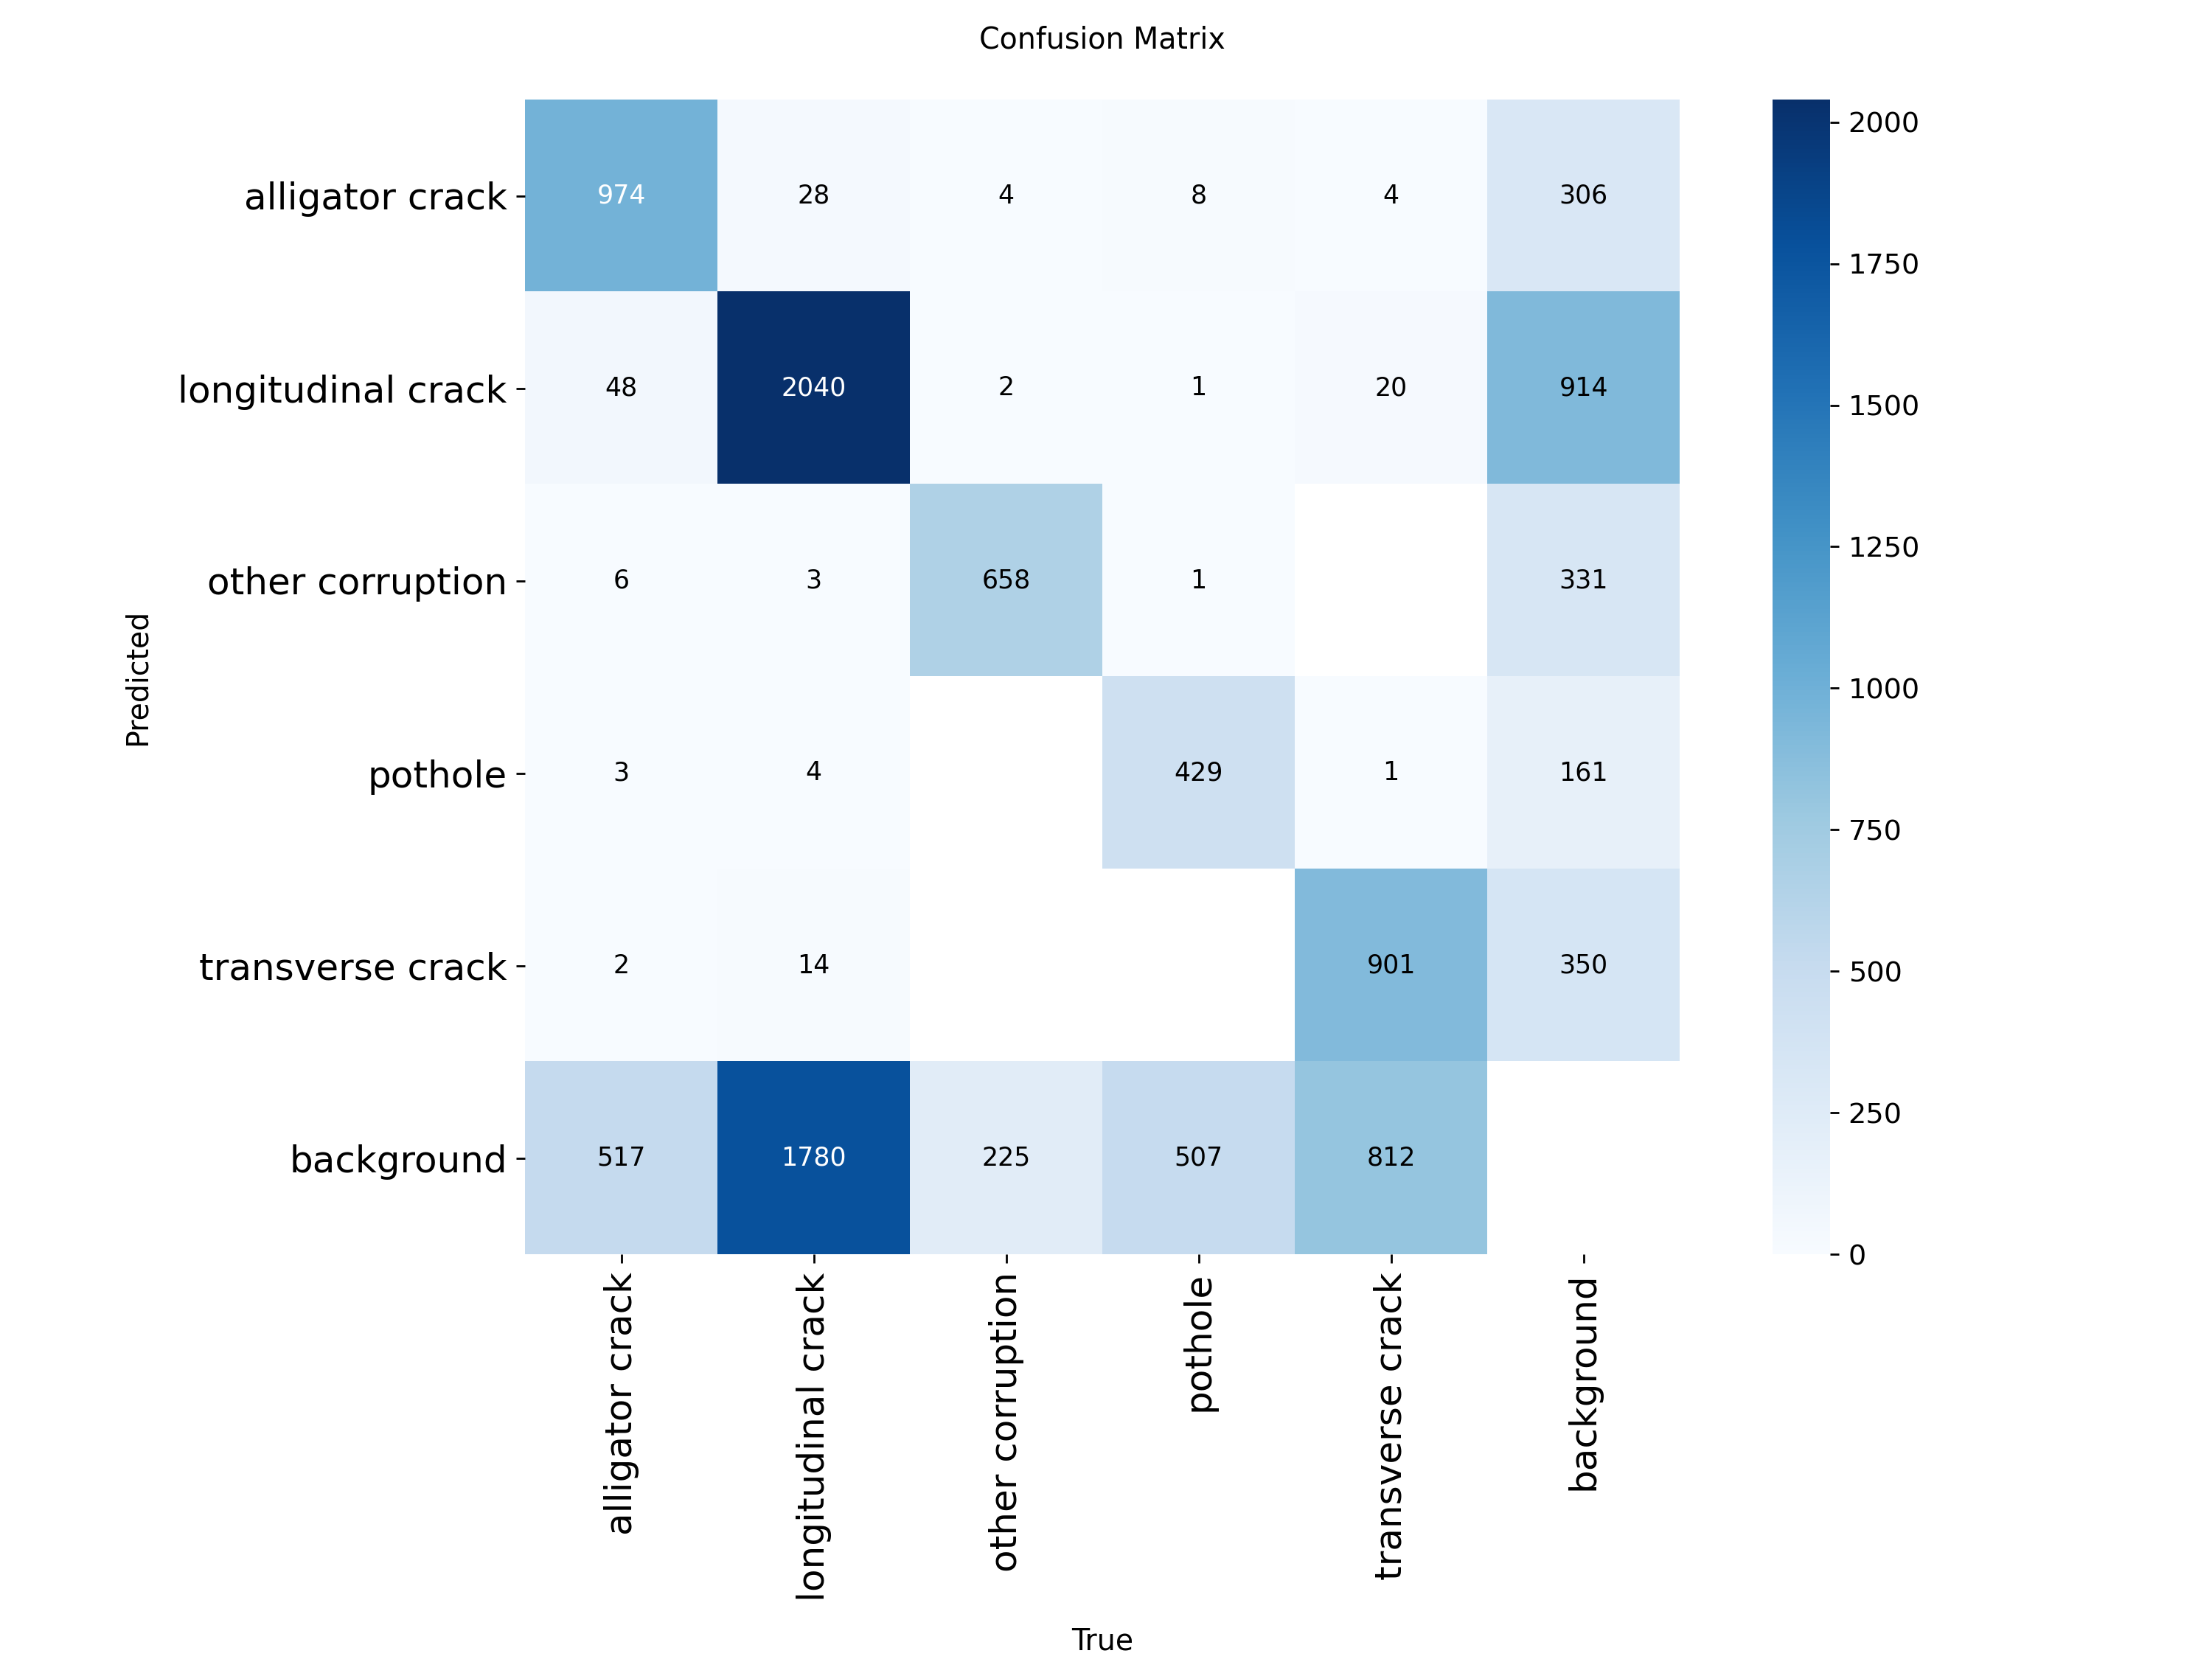

In [ ]:
import os
import glob
from IPython.display import Image as IPyImage, display

img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/confusion_matrix.png"

display(IPyImage(filename=img, width=600))



*   Most of the misclassification are due to a confusion with the background. Hence a lot of FP and FN.
*
* The model shows strong performance on longitudinal cracks (2040 correct predictions) and background class (1780 correct predictions), indicating good detection capability for these common classes.
* Performance varies significantly across damage types: transverse cracks (901 correct) and alligator cracks (974 correct) show moderate accuracy, while pothole detection (429 correct) is notably weaker, suggesting the need for more training data or augmentation for this class.
* Other corruption class shows 658 correct predictions but has substantial confusion with background (331 misclassified as background), indicating difficulty in distinguishing minor corruptions from normal road surface.
* Cross-class confusion is minimal between damage types (e.g., longitudinal vs transverse), suggesting the model has learned to differentiate between crack orientations effectively.  



### ***Losses curves analysis***

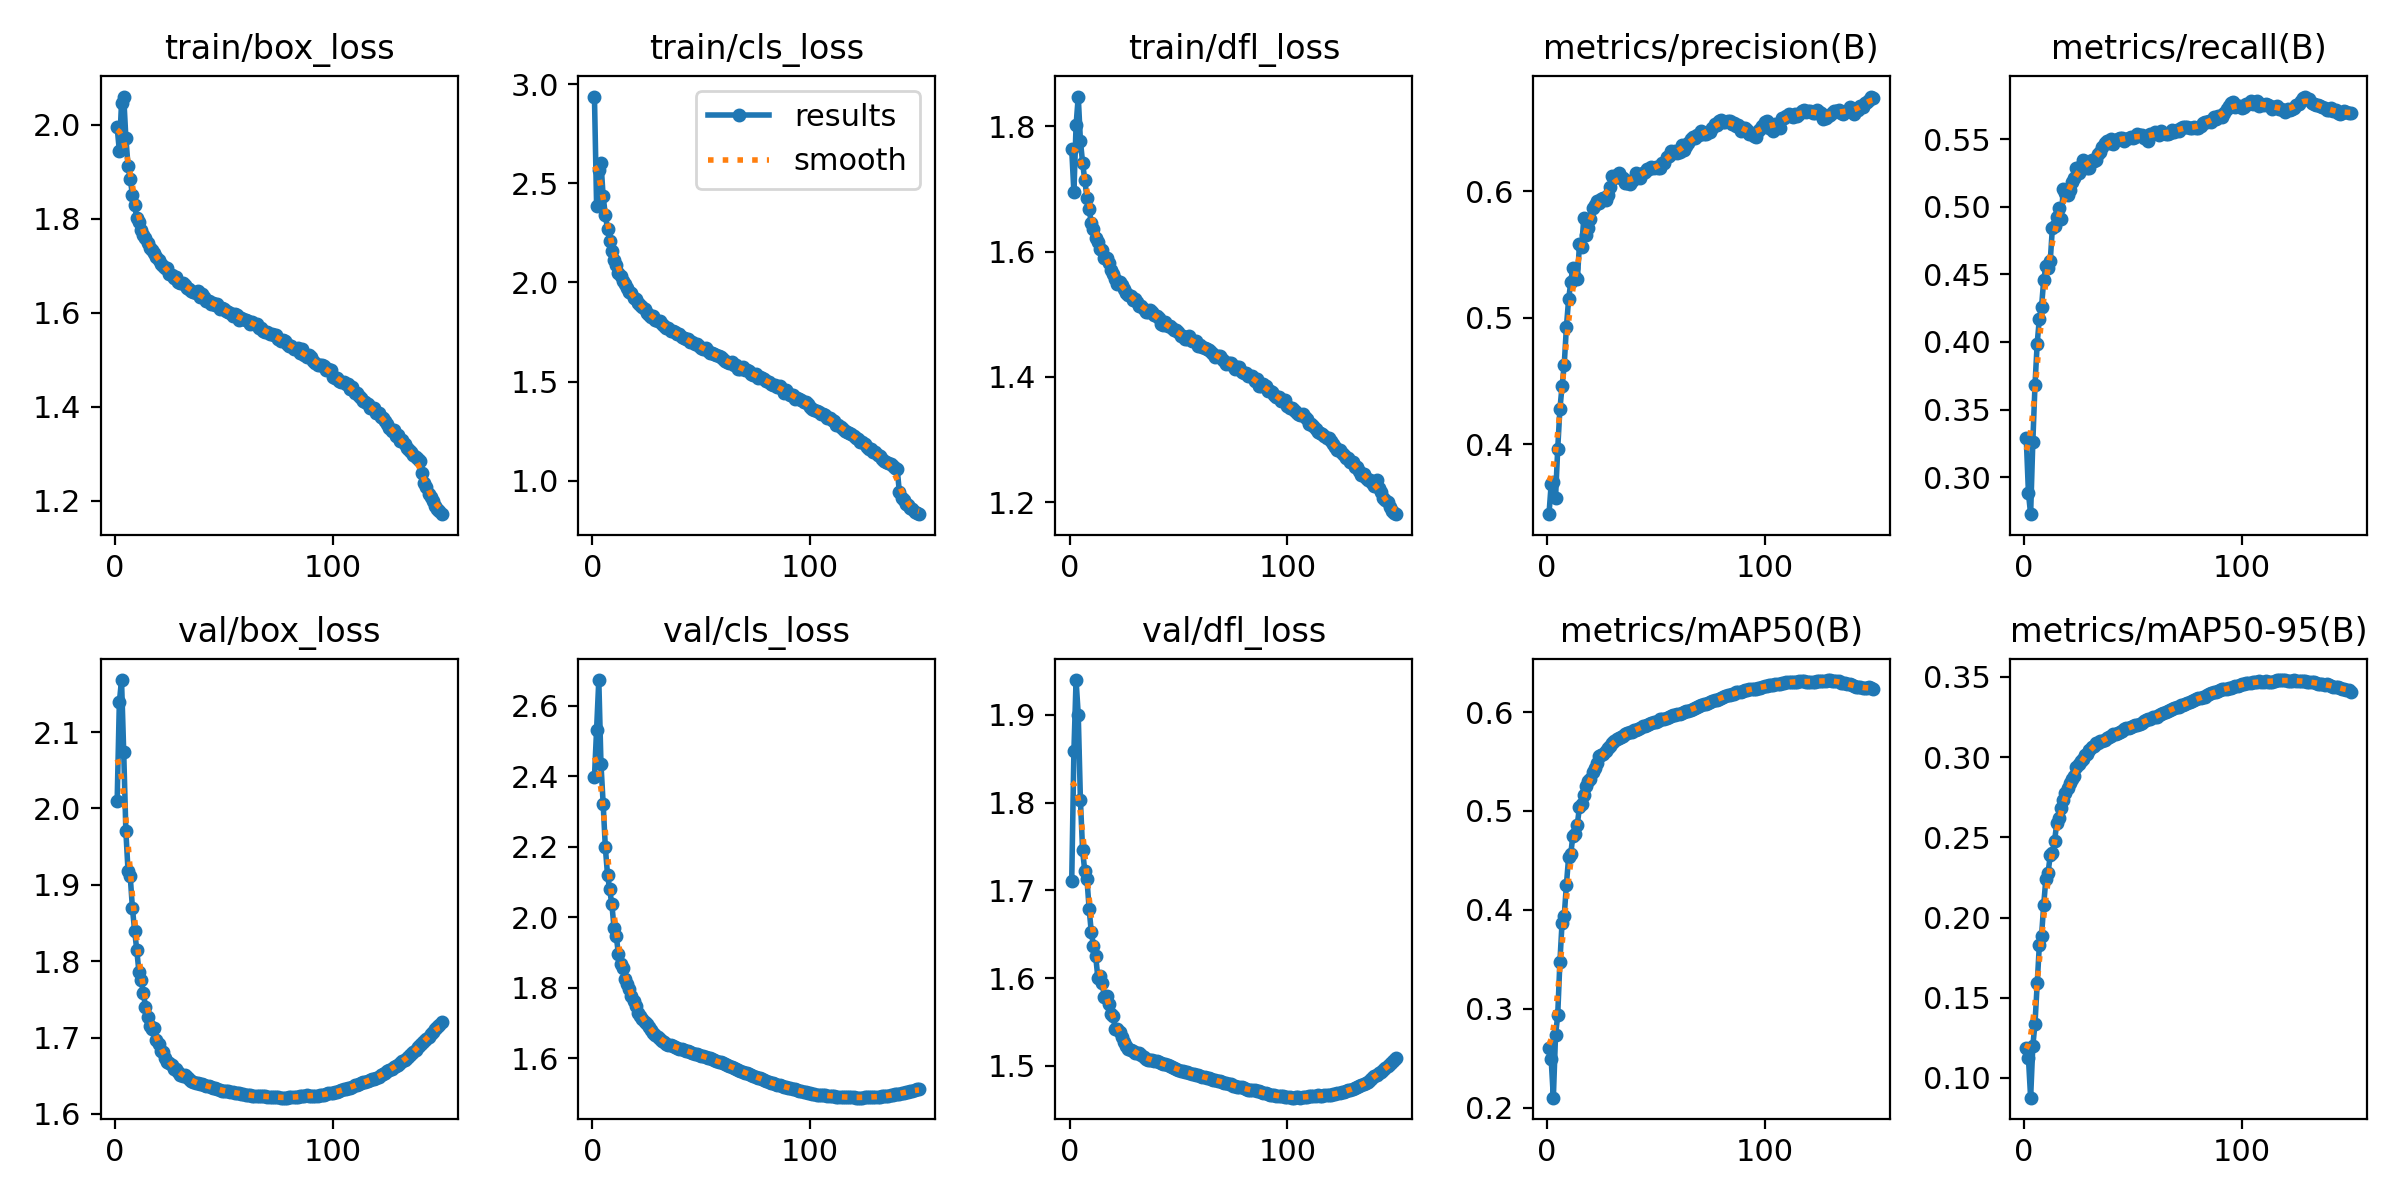

In [ ]:
img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/results.png"
display(IPyImage(filename=img, width=600))

* All three loss components (box, class, and dfl) show healthy convergence patterns, decreasing rapidly in the first 50 epochs and plateauing around epoch 100, indicating effective model learning.
* Training losses stabilize at low values (box_loss ~1.2, cls_loss ~1.0, dfl_loss ~1.5), suggesting the model has successfully learned to detect and classify road damage patterns.
* Validation losses follow similar trends to training losses with minimal gap, demonstrating good generalization without significant overfitting.
* Precision metric reaches ~0.55 and recall reaches ~0.55 by the end of training, showing balanced performance between false positives and false negatives.
* mAP@0.5 achieves ~0.35 while mAP@0.5:0.95 reaches ~0.20, indicating decent performance at IoU threshold 0.5 but room for improvement at stricter IoU thresholds, suggesting the model could benefit from better bounding box regression.

### ***Precision curve analysis***

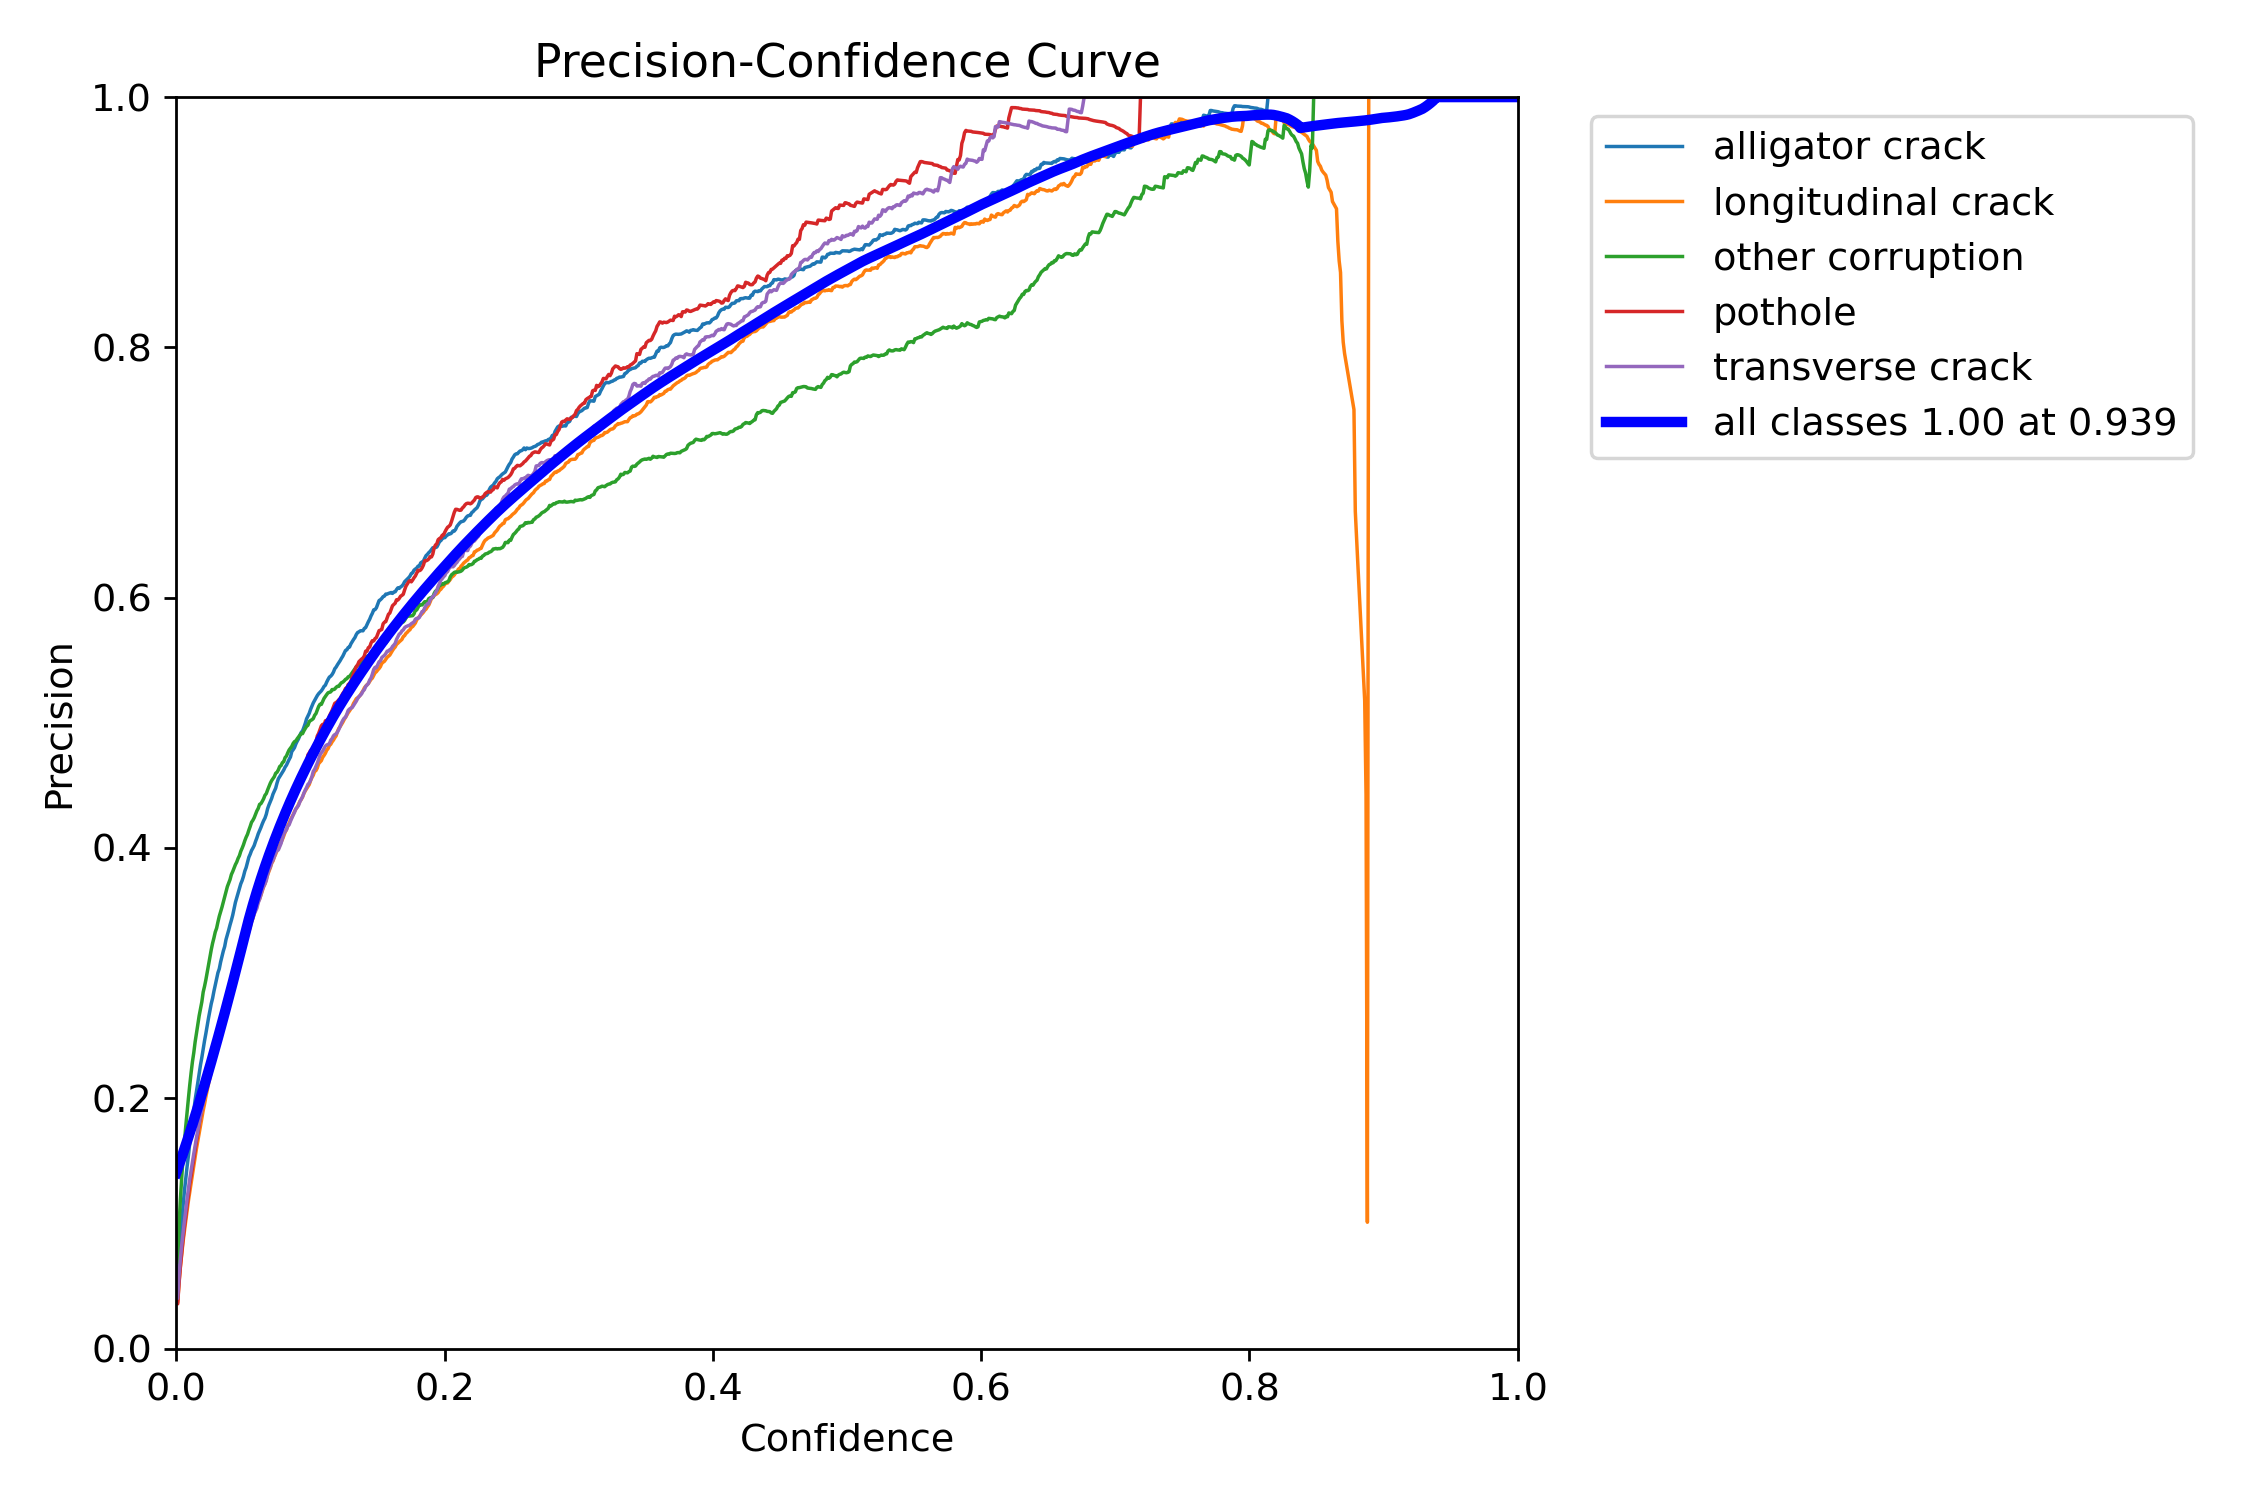

In [ ]:
img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/BoxP_curve.png"
display(IPyImage(filename=img, width=600))

* The curve shows that at high confidence thresholds (>0.8), the model achieves near-perfect precision (~1.0) for all classes, meaning predictions made with high confidence are highly reliable.
* As confidence threshold decreases, precision drops gradually, with most classes maintaining >0.8 precision until confidence drops below 0.4, indicating the model provides well-calibrated confidence scores.
* The model achieves optimal precision (1.00) at a confidence threshold of 0.939, suggesting that using a confidence threshold around 0.94 would filter out most false positives while retaining true positives.
* Other corruption (green line) shows the slowest precision increase compared to other classes, indicating this class has more uncertain predictions across various confidence levels.
* All damage types show similar precision behavior at high confidence (converging near 1.0), but diverge at lower confidence thresholds, with potholes and other corruptions showing lower precision, consistent with the confusion matrix findings.

### ***Recall curve analysis***

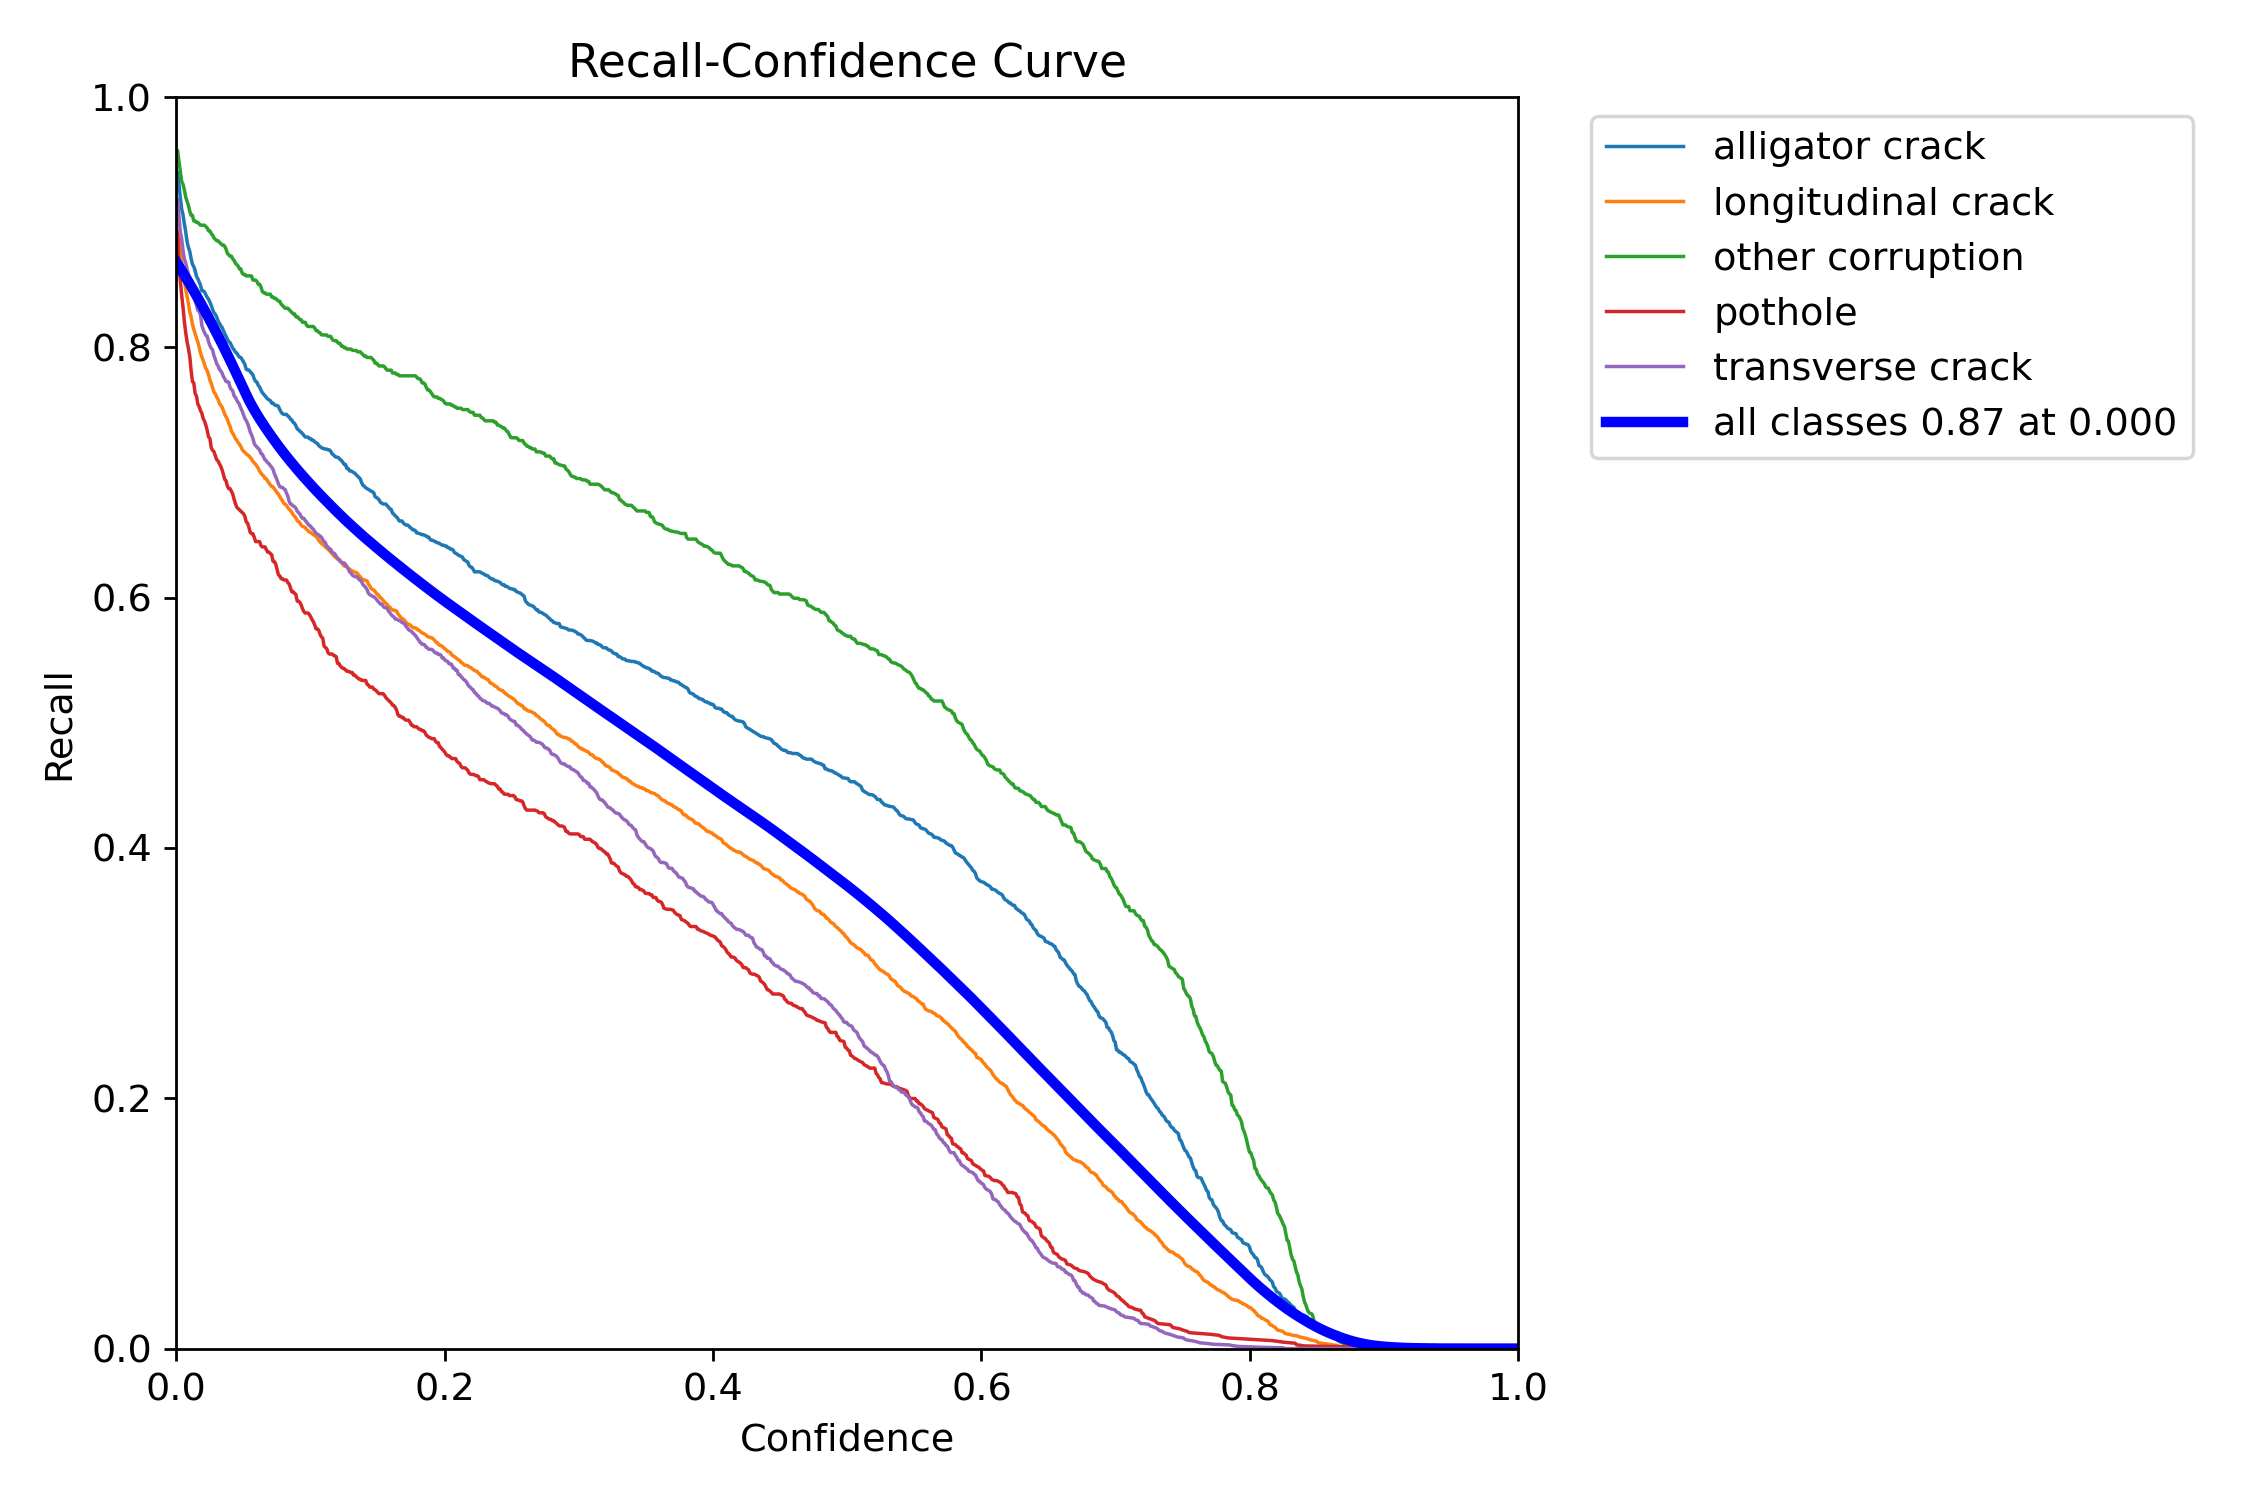

In [ ]:
img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/BoxR_curve.png"
display(IPyImage(filename=img, width=600))

* Unlike precision which increases with confidence, recall decreases as confidence threshold increases, showing the classic precision-recall tradeoff - stricter confidence requirements capture fewer true positives.
* At confidence threshold 0.0 (accepting all detections), the model achieves maximum recall of 0.87, meaning it can detect 87% of all road damage instances if we accept all predictions regardless of confidence.
* Other corruption (green line) maintains the highest recall across all confidence levels, starting at ~1.0 and degrading more slowly than other classes, suggesting the model is better at detecting this damage type even with varying confidence.
* Potholes (pink line) show the steepest decline in recall, dropping from ~0.6 to near 0 as confidence increases, indicating the model struggles to make high-confidence pothole predictions, consistent with the lower precision observed earlier.
* The optimal operating point for balanced precision-recall would be at confidence ~0.5-0.6 where most classes maintain 0.4-0.6 recall while achieving decent precision, though this depends on whether false positives or false negatives are more costly in the deployment scenario.

### ***Precision-Recall curve analysis***

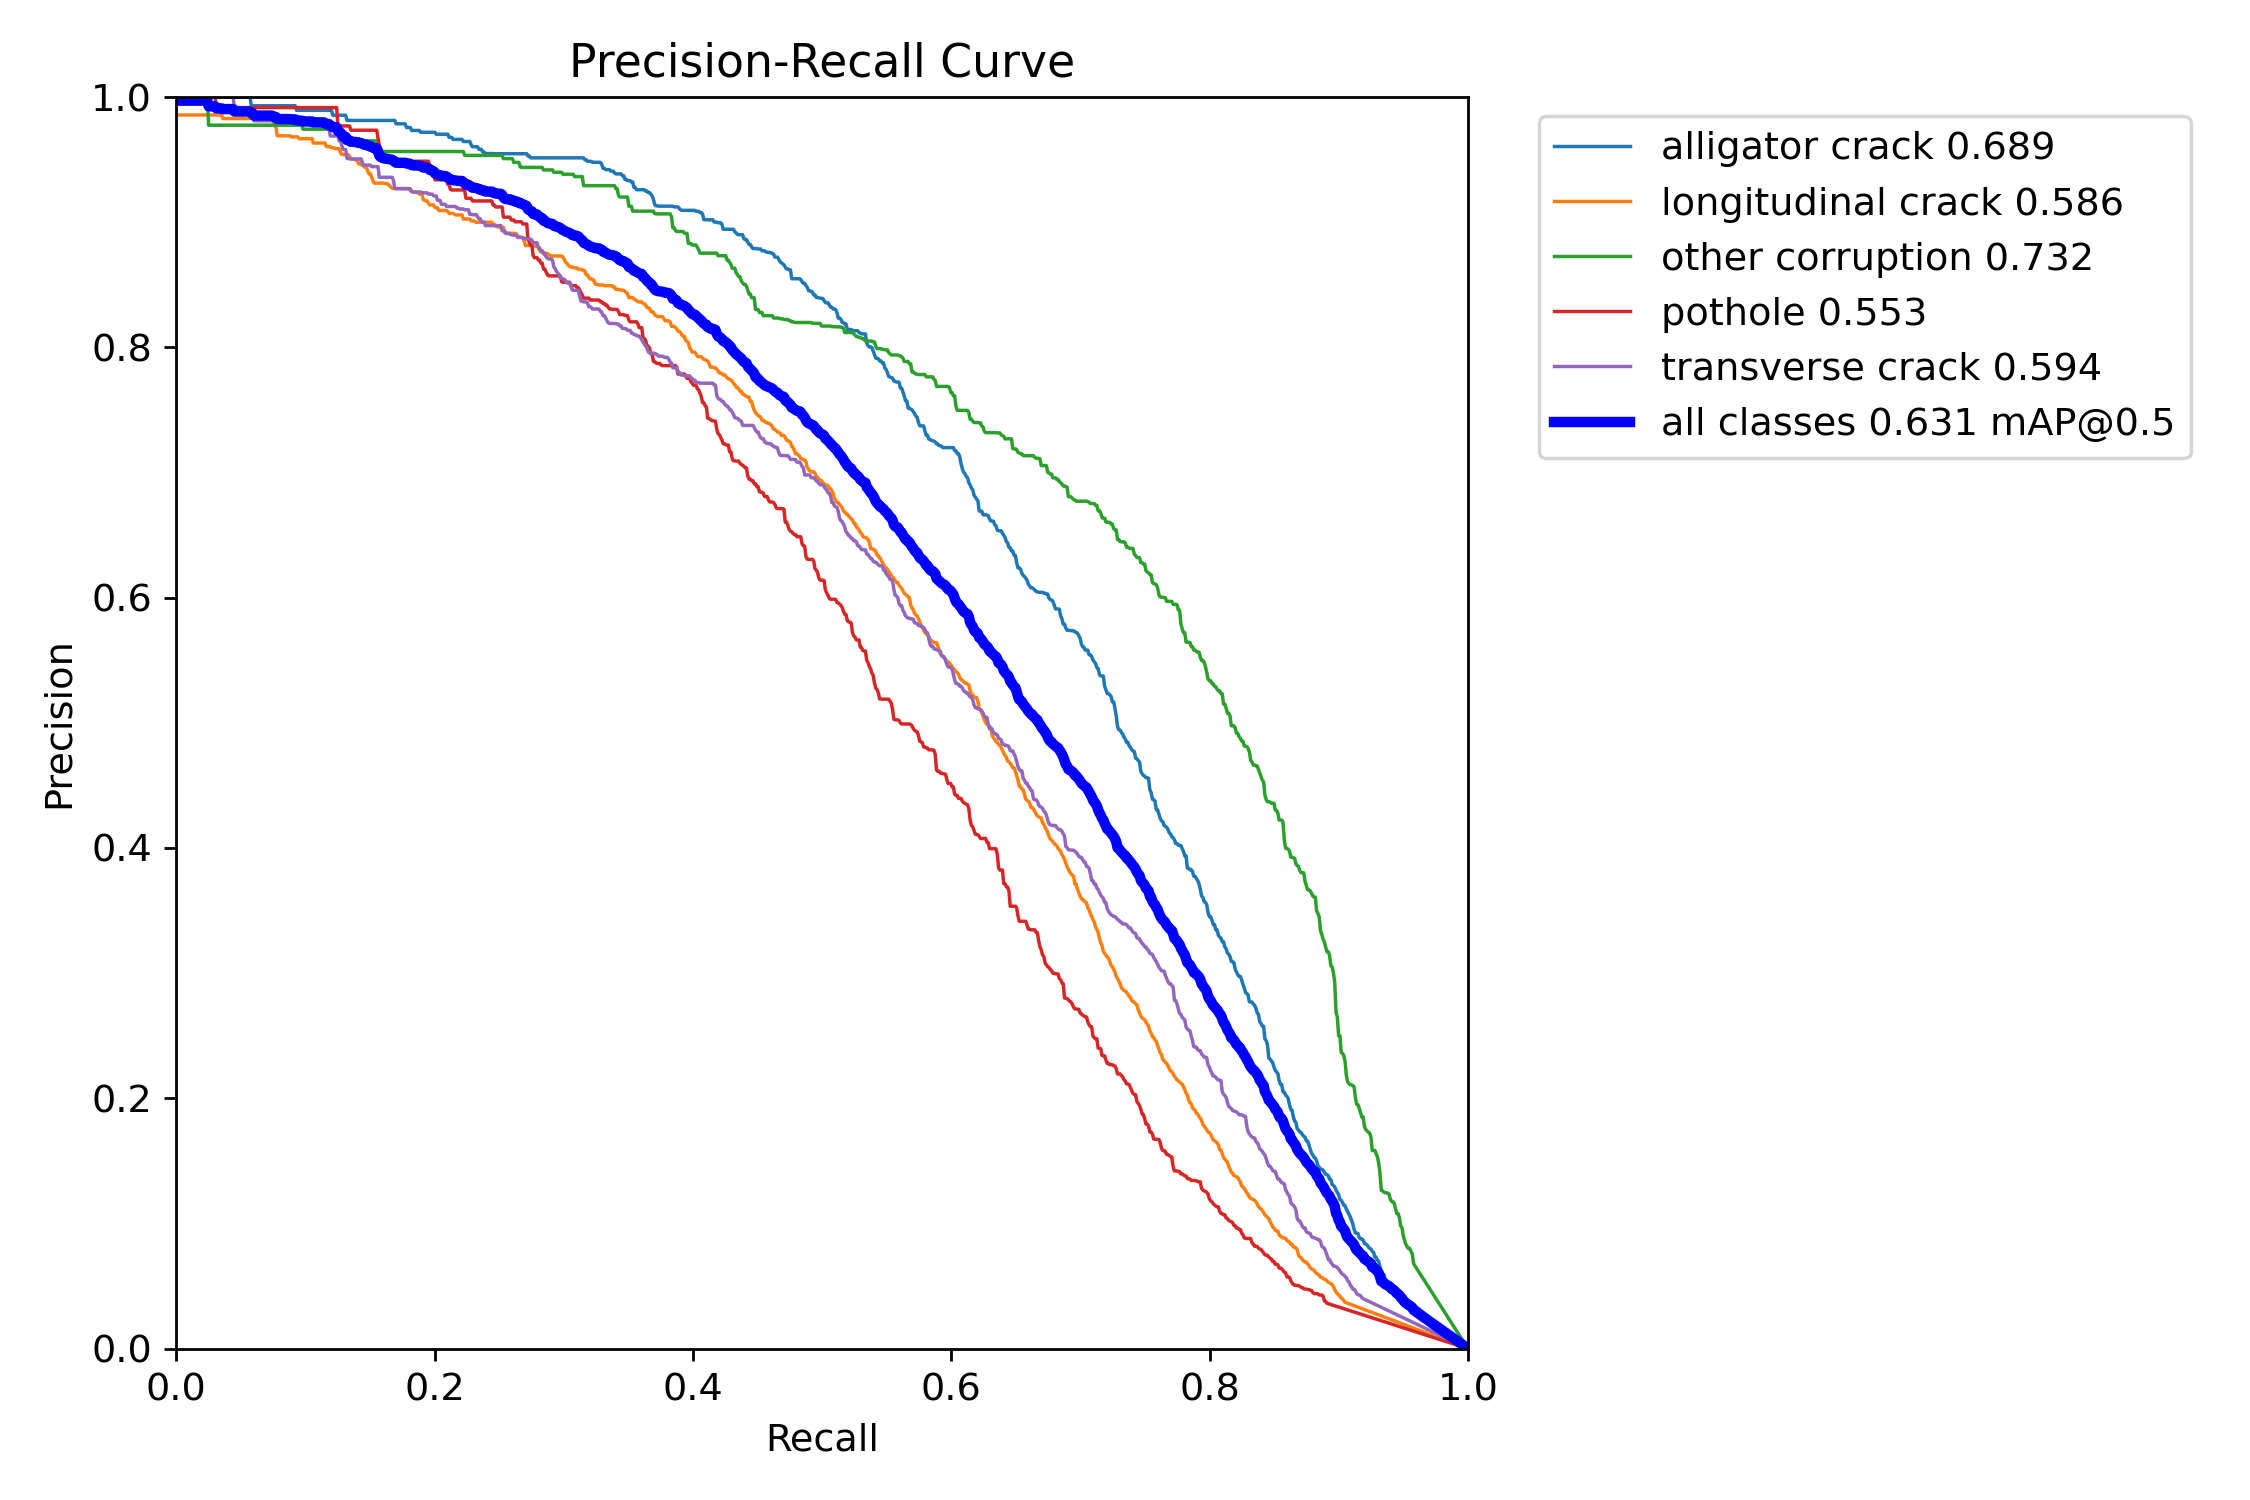

In [ ]:
img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/BoxPR_curve.png"
display(IPyImage(filename=img, width=600))

* The PR curve provides a comprehensive view of the precision-recall tradeoff across all operating points. The area under each curve (AP/mAP) quantifies overall detection performance for each class.
* Other corruption achieves the highest mAP@0.5 of 0.732, followed by alligator crack (0.689) and transverse crack (0.594), while longitudinal crack (0.586) and pothole (0.553) show lower performance, consistent with previous observations.
* The overall mAP@0.5 of 0.631 indicates moderate detection performance - the model correctly detects and classifies about 63% of road damage instances at IoU threshold 0.5.
* Most classes maintain high precision (>0.8) at low recall levels (0-0.4), but precision drops significantly as recall increases beyond 0.6, indicating the model struggles to detect all instances while maintaining accuracy.
* The curves show varying shapes: other corruption maintains better precision at higher recall (broader curve), while pothole shows rapid precision degradation (narrower curve), suggesting pothole detection requires further improvement through data augmentation or architecture modifications.

### ***F1 curve analysis***

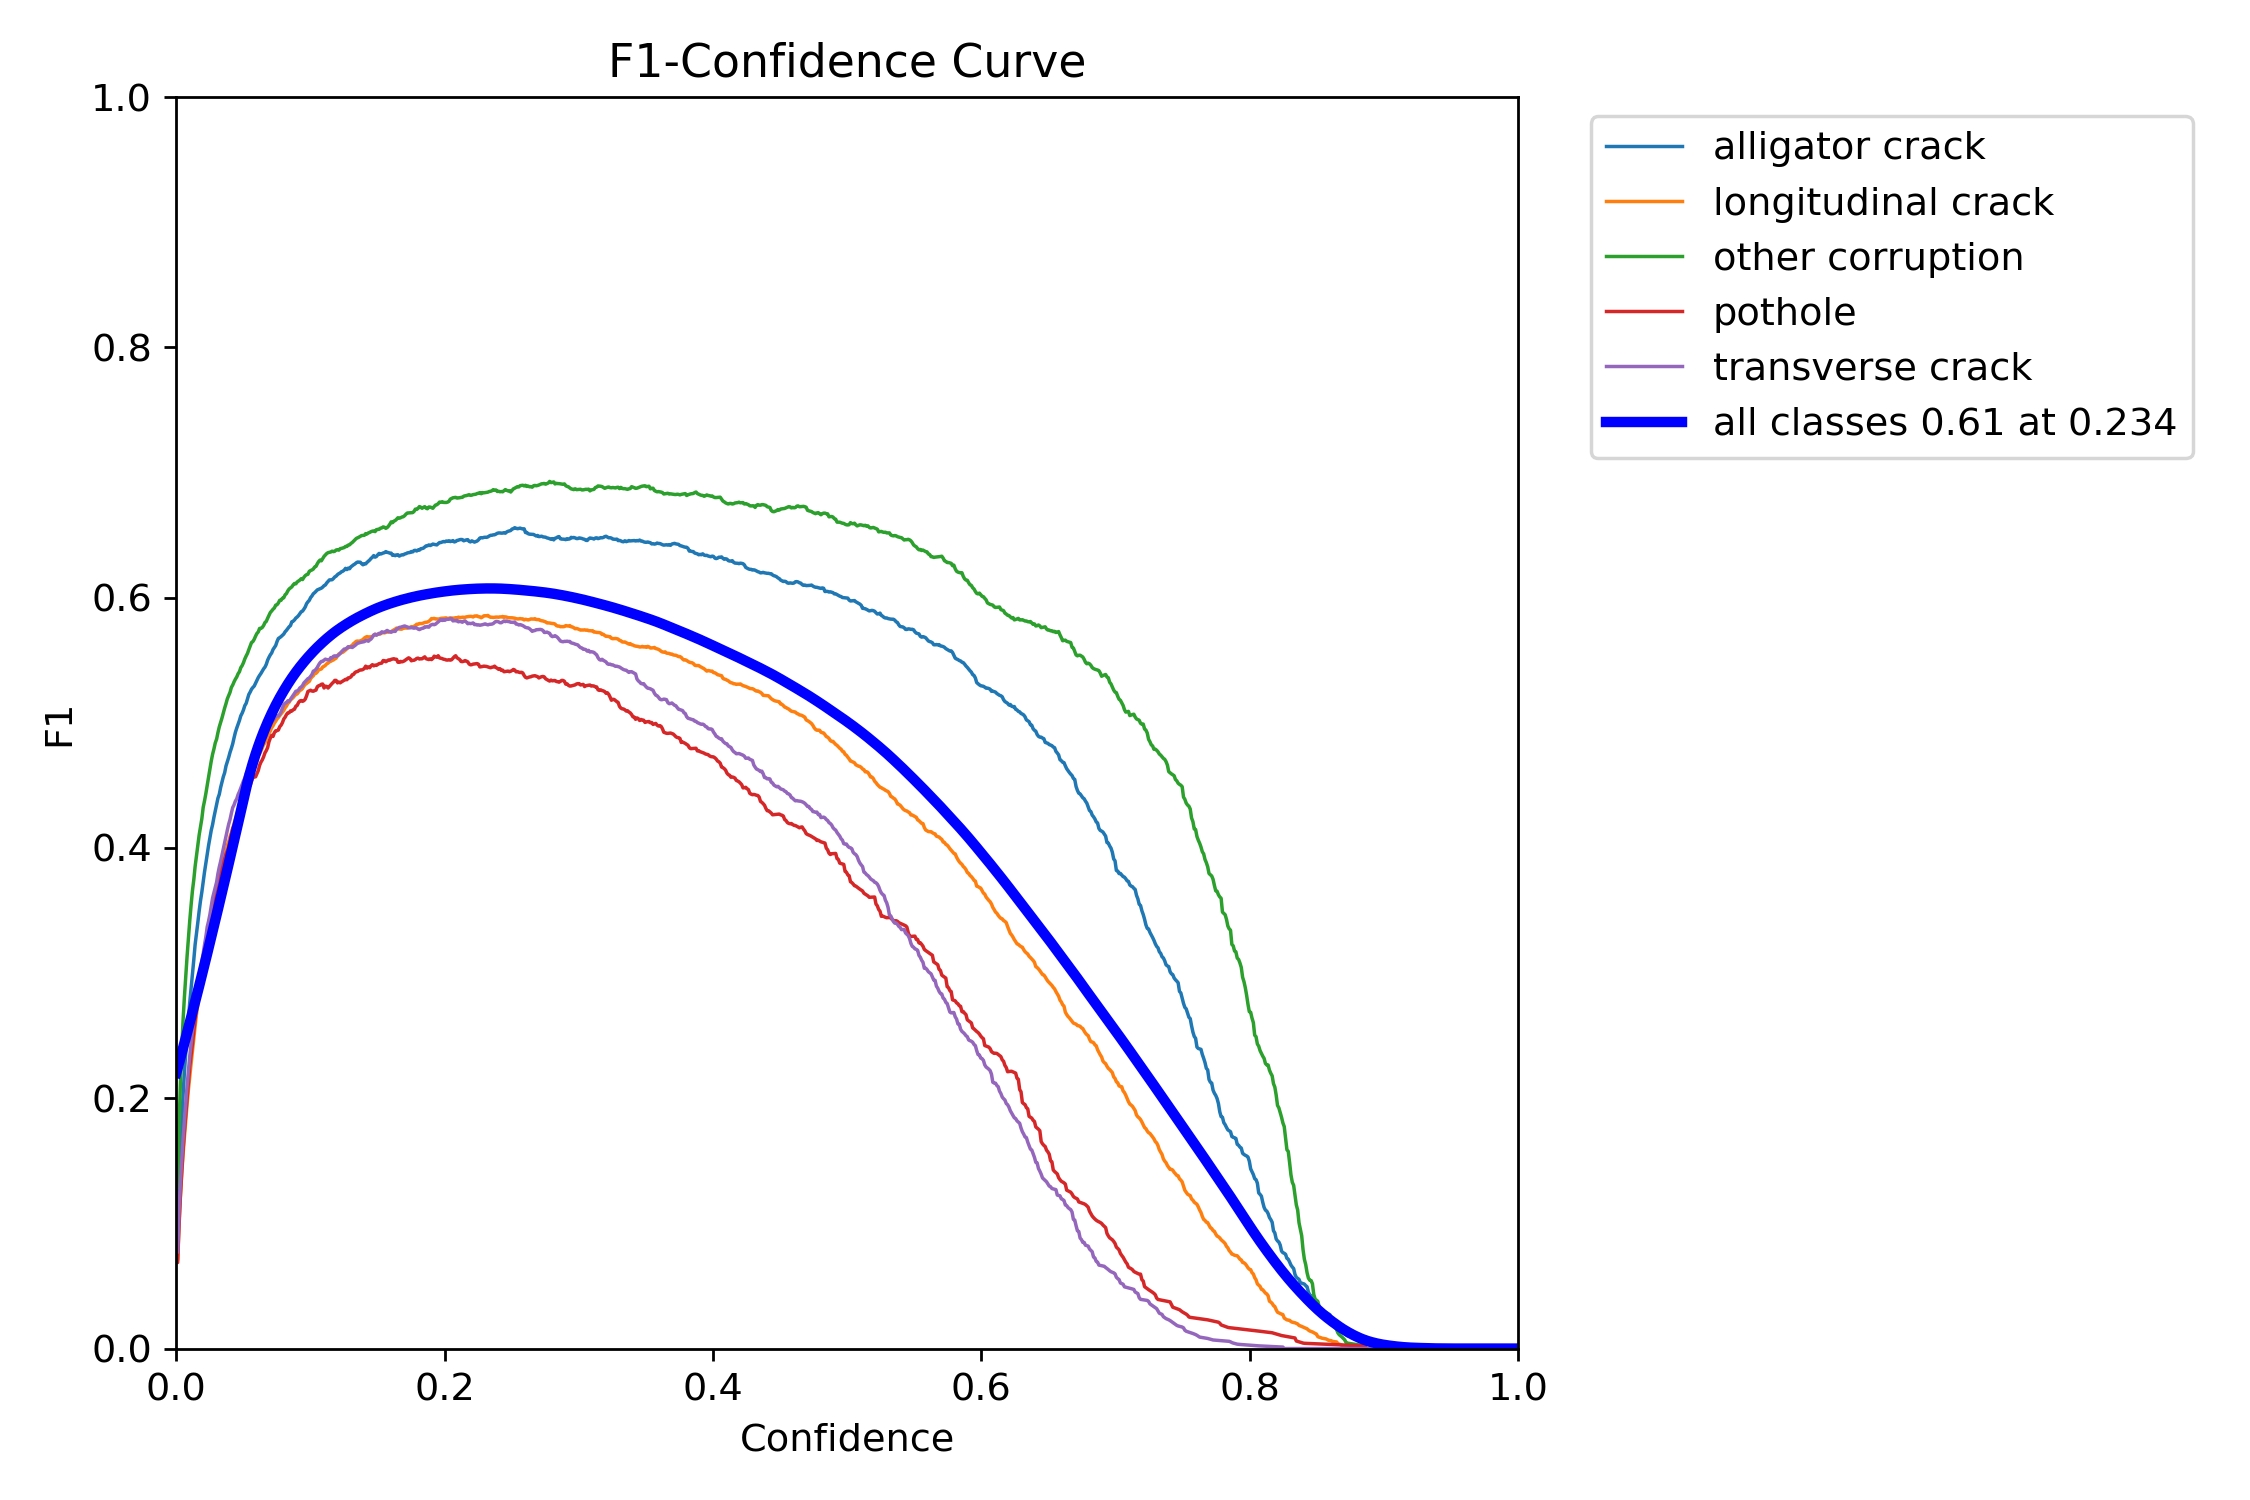

In [ ]:
img = "/content/drive/MyDrive/YOLO_RoadDamage/checkpoints/yolov11s_20251113_180428/BoxF1_curve.png"
display(IPyImage(filename=img, width=600))

* The F1-score curve represents the harmonic mean of precision and recall, providing a single metric that balances both aspects of detection performance across different confidence thresholds.
* All classes show a characteristic bell-shaped curve, indicating there's an optimal confidence threshold that maximizes the F1-score for each class, balancing the precision-recall tradeoff.
* The model achieves its best overall F1-score of 0.61 at a confidence threshold of 0.234, which is relatively low, suggesting the model performs best when being more lenient with detections rather than overly conservative.
* Other corruption (green line) achieves the highest peak F1-score (~0.70 at confidence ~0.3), while pothole shows the lowest peak F1-score (~0.55 at confidence ~0.15), reaffirming that pothole detection is the weakest aspect of the model.
* The narrow peaks and rapid decline at higher confidence thresholds indicate the model is sensitive to threshold selection - choosing a threshold too high dramatically reduces detection performance, suggesting deployment should use confidence thresholds in the 0.2-0.4 range for optimal balanced performance.

### **To do next ...**

Based on the comprehensive analysis of the model performance, here are the recommended next steps to improve the road damage detection system:

## 1. Data Improvements

* **Pothole class augmentation**: Collect more pothole samples or apply aggressive data augmentation (rotation, scaling, brightness adjustment) to improve the weakest-performing class (mAP@0.5: 0.553)
* **Background handling**: Reduce false positives by:
  - Adding more challenging negative samples (clear roads with varying conditions)
  - Implementing hard negative mining during training
  - Reviewing and refining annotations for background confusion cases (317 FPs, 225 FNs)
* **Address class imbalance**: Balance training data across all damage types, particularly for underrepresented classes

## 2. Model Architecture & Training

* **Improve bounding box regression**: The gap between mAP@0.5 (0.631) and mAP@0.5:0.95 (0.20) suggests poor localization
  - Experiment with different IoU loss functions (GIoU, DIoU, CIoU)
  - Fine-tune box loss weight in the loss function
  - Consider using attention mechanisms for better spatial localization
* **Extended training**: Continue training beyond current epochs with:
  - Lower learning rate for fine-tuning
  - Monitoring for performance improvements
* **Hyperparameter optimization**: Conduct systematic grid search or Bayesian optimization for:
  - Learning rate schedule
  - Loss function weights
  - Augmentation parameters

## 3. Threshold Selection & Validation

* **Implement optimal confidence thresholds**: Deploy with confidence threshold in 0.2-0.4 range for balanced F1-score (0.61 at 0.234)
* **Class-specific thresholds**: Consider per-class confidence thresholds:
  - Other corruption: ~0.3 (F1: 0.70)
  - Pothole: ~0.15 (F1: 0.55)
* **Validation on real-world data**: Test model on diverse road conditions, lighting, and weather scenarios
* **Create validation scripts**: Implement automated threshold selection based on deployment requirements (precision vs recall priority)

## 4. Model Ensemble & Post-processing

* **Ensemble methods**: Train multiple models with different:
  - Architectures (YOLOv8, YOLOv9, YOLO-NAS)
  - Backbone networks
  - Training strategies
* **Post-processing improvements**:
  - Implement custom NMS strategies for overlapping damage regions
  - Add temporal consistency for video-based detection
  - Apply morphological operations for boundary refinement

## 5. Deployment Considerations

* **Model optimization**:
  - Quantization for faster inference
  - Model pruning to reduce size
  - Export to ONNX/TensorRT for production deployment
* **A/B testing**: Deploy current model alongside baseline to measure real-world performance improvements
* **Monitoring pipeline**: Set up continuous monitoring for:
  - Inference time
  - Prediction distribution
  - Edge case detection

## 6. Additional Experiments

* **Multi-scale training**: Train with varying input resolutions to improve detection of small damages
* **Focal loss**: Experiment with focal loss to address class imbalance and hard example mining
* **Transfer learning**: Fine-tune from models pre-trained on similar infrastructure/defect detection tasks
* **Synthetic data generation**: Use GANs or diffusion models to generate additional training samples for underrepresented classes

## Priority Order
1. **High Priority**: Pothole augmentation, confidence threshold optimization, bounding box loss improvement
2. **Medium Priority**: Extended training, class-specific thresholds, validation scripts
3. **Lower Priority**: Ensemble methods, model quantization, synthetic data generation